In [9]:
import sympy
import csv
import matplotlib.style
from sympy.plotting.plot import List2DSeries

matplotlib.style.use('bmh')

In [10]:
def lagrangeInterpolation(Lx, Ly):
    """
    Calculate polynomial using Lagrange interpolation method
    """
    x = sympy.Symbol('x')

    y = 0
    for i in range(len(Lx)):
        t = 1
        for j in range(len(Lx)):
            if j != i:
                t *= ((x-Lx[j]) / (Lx[i]-Lx[j]))
        y += t*Ly[i]

    return y

In [11]:
def newtonsDividedDifferenceInterpolation(Lx, Ly):
    """
    Calculate polynomial using Newton's Divided Difference interpolation method
    """
    x = sympy.Symbol('x')

    # finding Newton basis
    b = [0]*len(Lx)
    for i in range(1, len(Lx)):
        basis = 1
        for j in range(1, i+1):
            basis = basis*(x-Lx[j-1])
        b[i] = basis
    b[0] = 1

    # finding Newton coefficients (using a grid of coefficients)
    z = [[0]*len(Lx) for _ in range (len(Lx))]
    for i in range(0, len(Lx)):  # first column
        z[i][0] = Ly[i]
    for i in range(1, len(Lx)):
        for j in range(0, len(Lx)-i):
            z[j][i] = (z[j+1][i-1]-z[j][i-1]) / (Lx[i]-Lx[0])

    # forming interpolating polynomial
    y = Ly[0]
    for i in range(1, len(Lx)):
        y = y + b[i]*z[0][i]
    
    return y

In [12]:
def linearSplineInterpolation(Lx, Ly):
    """
    Calculate polynomial using Linear Spline interpolation method
    """
    x = sympy.Symbol('x')

    y = []
    for i in range(1, len(Lx)):
        y.append(Ly[i-1] + ((Ly[i]-Ly[i-1]) / (Lx[i]-Lx[i-1]))*(x-Lx[i-1]))

    return y

In [13]:
def cubicSplineInterpolation(Lx, Ly):
    """
    Calculate polynomial using Cubic Spline interpolation method
    """
    x = sympy.Symbol('x')
    
    y = []
    coefficients = computeSpline(Lx, Ly)
    
    for i, spline_coeffs in enumerate(coefficients):
        spline = 0
        z = (x-Lx[i])/(Lx[i+1]-Lx[i])
        for term in range(len(spline_coeffs)):
            spline += (z**term)*spline_coeffs[3-term]
        y.append(spline) 

    return y

def computeSpline(x, y):
    n = len(x)

    h = [x[i+1] - x[i] for i in range(len(x) - 1)]

    # tridiagonal matrix
    A = [h[i] / (h[i] + h[i + 1]) for i in range(n - 2)] + [0]
    B = [2] * n
    C = [0] + [h[i + 1] / (h[i] + h[i + 1]) for i in range(n - 2)]
    
    D = [0] +\
        [6 *
         ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1]) /
         (h[i] + h[i-1]) for i in range(1, n - 1)
        ] +\
        [0]

    # solve tridiagonal system using Thomas algorithm
    M = solveTridiagonalSystem(A, B, C, D)

    coefficients = [[(M[i+1]-M[i])*h[i]*h[i]/6,
                     M[i]*h[i]*h[i]/2,
                     (y[i+1] - y[i] - ((M[i+1]+2*M[i])*h[i]*h[i]/6)),
                     y[i]] for i in range(n-1)]
    
    return coefficients

def solveTridiagonalSystem(A, B, C, D):
    c_p = C + [0]
    d_p = [0] * len(B)
    X = [0] * len(B)

    c_p[0] = C[0] / B[0]
    d_p[0] = D[0] / B[0]
    for i in range(1, len(B)):
        c_p[i] = c_p[i] / (B[i] - c_p[i - 1] * A[i - 1])
        d_p[i] = (D[i] - d_p[i - 1] * A[i - 1]) / (B[i] - c_p[i - 1] * A[i - 1])

    X[-1] = d_p[-1]
    for i in range(len(B) - 2, -1, -1):
        X[i] = d_p[i] - c_p[i] * X[i + 1]

    return X

In [14]:
# CONSTANTS FOR PLOTTING
x = sympy.symbols('x')
x_limit = 100
absolute_income_equality = x  # at absolute equality, lorenz curve is a straight line
area_equality = sympy.integrate(absolute_income_equality,
                                (sympy.Symbol('x'), 0, x_limit))

In [15]:
def plotLagrange(Lx, Ly, GINI_KNOWN):
    """
    Show details and plot Lorenz curve obtained using Lagrange method
    """
    lagrange_poly = lagrangeInterpolation(Lx, Ly)
    lagrange_lorenz = sympy.simplify(lagrange_poly)

    area_equality = sympy.integrate(absolute_income_equality,
                                    (sympy.Symbol('x'), 0, x_limit))
    area_gini = sympy.integrate(absolute_income_equality-lagrange_lorenz,
                                (sympy.Symbol('x'), 0, x_limit))

    lagrange_gini = area_gini/area_equality
    lagrange_accuracy = abs(100.0 - (abs(GINI_KNOWN-lagrange_gini) / GINI_KNOWN) * 100.0)

    print("\n\n\tLAGRANGE INTERPOLATION\n{}".format('-'*100))
    print("Lagrange Polynomial:\n", lagrange_lorenz)
    print("\nEnclosed Area: ", area_gini)
    print("\nEquality Area: ", area_equality)
    print("\nGini Coefficient: ", lagrange_gini)
    print("\nAccuracy: {:0.2f}% ".format(lagrange_accuracy))

    # Plot
    p_lagrange = sympy.plotting.plot(lagrange_lorenz,
                                     absolute_income_equality,
                                     (x, 0, x_limit),
                                     ylim=[0, 110],
                                     show=False)
    p_lagrange.title = "Lagrange Interpolation\nfor Gini Approximation"
    p_lagrange.xlabel = "Population\nPercentage"
    p_lagrange.ylabel = "Income\nShare\nPercentage"
    p_lagrange[1].line_color = '#17ab09'
    p_lagrange[0].line_color = '#098fab'

    p_lagrange.show()

In [16]:
def plotNewton(Lx, Ly, GINI_KNOWN):
    """
    Show details and plot Lorenz curve obtained using Netwon method
    """
    newton_poly = newtonsDividedDifferenceInterpolation(Lx, Ly)
    newton_lorenz = sympy.simplify(newton_poly)

    area_equality = sympy.integrate(absolute_income_equality,
                                    (sympy.Symbol('x'), 0, x_limit))
    area_gini = sympy.integrate(absolute_income_equality-newton_lorenz,
                                (sympy.Symbol('x'), 0, x_limit))

    newton_gini = area_gini/area_equality
    newton_accuracy = abs(100.0 - (abs(GINI_KNOWN-newton_gini) / GINI_KNOWN) * 100.0)

    print("\n\n\tNEWTON'S DIVIDED DIFFERENCE INTERPOLATION\n{}".format('-'*100))
    print("Newton Polynomial:\n", newton_lorenz)
    print("\nEnclosed Area: ", area_gini)
    print("\nEquality Area: ", area_equality)
    print("\nGini Coefficient: ", newton_gini)
    print("\nAccuracy: {:0.2f}% ".format(newton_accuracy))

    # Plot
    p_newton = sympy.plotting.plot(newton_lorenz,
                                   absolute_income_equality,
                                   (x, 0, x_limit),
                                   ylim=[0, 110],
                                   show=False)
    p_newton.title = "Newton's Divided Difference Interpolation\nfor Gini Approximation"
    p_newton.xlabel = "Population\nPercentage"
    p_newton.ylabel = "Income\nShare\nPercentage"
    p_newton[1].line_color = '#17ab09'
    p_newton[0].line_color = '#098fab'

    p_newton.show()

In [17]:
def plotLinearSpline(Lx, Ly, GINI_KNOWN):
    """
    Show details and plot Lorenz curve obtained using Linear Spline method
    """
    linear_spline_polys = linearSplineInterpolation(Lx, Ly)

    # multiple polynomials/splines
    linear_spline_lorenz = []
    area_gini = 0
    to_plot = []
    for i in range(len(Lx)-1):
        # simplify polynomials
        poly = sympy.simplify(linear_spline_polys[i])
        linear_spline_lorenz.append(poly)

        # calculate areas
        area_gini +=sympy.integrate(absolute_income_equality-linear_spline_lorenz[i],
                                    (sympy.Symbol('x'), Lx[i], Lx[i+1]))

        # generate tuples for plotting
        to_plot.append((poly, (x, Lx[i], Lx[i+1])))


    linear_spline_gini = area_gini/area_equality
    linear_spline_accuracy = abs(100.0 - (abs(GINI_KNOWN-linear_spline_gini) / GINI_KNOWN) * 100.0)

    print("\n\n\tLINEAR SPLINE INTERPOLATION\n{}".format('-'*100))
    print("Linear Spline Polynomials:", *linear_spline_lorenz, sep='\n')
    print("\nEnclosed Area: ", area_gini)
    print("\nEquality Area: ", area_equality)
    print("\nGini Coefficient: ", linear_spline_gini)
    print("\nAccuracy: {:0.2f}% ".format(linear_spline_accuracy))

    # Plot
    p_linear_spline = sympy.plotting.plot(absolute_income_equality,
                                          (x, 0, x_limit),
                                          ylim=[0, 110],
                                          show=False)
    for i in range(0, len(to_plot)):
        plt = sympy.plotting.plot(to_plot[i], show=False)
        p_linear_spline.extend(plt)
        p_linear_spline[-1].line_color='#098fab'

    p_linear_spline.title = "Linear Spline Interpolation\nfor Gini Approximation"
    p_linear_spline.xlabel = "Population\nPercentage"
    p_linear_spline.ylabel = "Income\nShare\nPercentage"
    p_linear_spline[0].line_color = '#17ab09'

    p_linear_spline.show()

In [18]:
def plotCubicSpline(Lx, Ly, GINI_KNOWN):
    """
    Show details and plot Lorenz curve obtained using Cubic Spline method
    """
    cubic_spline_polys = cubicSplineInterpolation(Lx, Ly)

    # multiple polynomials/splines
    cubic_spline_lorenz = []
    area_gini = 0
    to_plot = []
    for i in range(len(Lx)-1):
        # simplify polynomials
        poly = sympy.simplify(cubic_spline_polys[i])
        cubic_spline_lorenz.append(poly)

        # calculate areas
        area_gini +=sympy.integrate(absolute_income_equality-cubic_spline_lorenz[i],
                                    (sympy.Symbol('x'), Lx[i], Lx[i+1]))

        # generate tuples for plotting
        to_plot.append((poly, (x, Lx[i], Lx[i+1])))


    cubic_spline_gini = area_gini/area_equality
    cubic_spline_accuracy = abs(100.0 - (abs(GINI_KNOWN-cubic_spline_gini) / GINI_KNOWN) * 100.0)

    print("\n\n\tCUBIC SPLINE INTERPOLATION\n{}".format('-'*100))
    print("Cubic Spline Polynomials:", *cubic_spline_lorenz, sep='\n')
    print("\nEnclosed Area: ", area_gini)
    print("\nEquality Area: ", area_equality)
    print("\nGini Coefficient: ", cubic_spline_gini)
    print("\nAccuracy: {:0.2f}% ".format(cubic_spline_accuracy))

    # Plot
    p_cubic_spline = sympy.plotting.plot(absolute_income_equality,
                                          (x, 0, x_limit),
                                          ylim=[0, 110],
                                          show=False)
    for i in range(0, len(to_plot)):
        plt = sympy.plotting.plot(to_plot[i], show=False)
        p_cubic_spline.extend(plt)
        p_cubic_spline[-1].line_color='#098fab'

    p_cubic_spline.title = "Cubic Spline Interpolation\nfor Gini Approximation"
    p_cubic_spline.xlabel = "Population\nPercentage"
    p_cubic_spline.ylabel = "Income\nShare\nPercentage"
    p_cubic_spline[0].line_color = '#17ab09'

    p_cubic_spline.show()

In [19]:
def calculateGiniForCountry(country, known_gini):
    """
    Calculate a country's Gini coefficient
    and plot Lorenz Curve using 4 interpolation methods
    """
    # Given data
    Lx = [0.0]
    Ly = [0.0]
    with open(f'data/{country.lower()}_input_hrv.csv', 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            Lx.append(float(row[0])*10)
            Ly.append(float(row[1]))

    # Cumulative data
    for idx in range(1, len(Ly)):
        Ly[idx] += Ly[idx-1]
        Ly[idx] = round(Ly[idx], 2)

    print(f"\n\tINPUT DATA FOR {country.upper()}\n{'-'*100}")
    print("X Vector: ", Lx)
    print("Y Vector: ", Ly)

    plotLagrange(Lx, Ly, known_gini)
    plotNewton(Lx, Ly, known_gini)
    plotLinearSpline(Lx, Ly, known_gini)
    plotCubicSpline(Lx, Ly, known_gini)


	INPUT DATA FOR ICELAND
----------------------------------------------------------------------------------------------------
X Vector:  [0.0, 20.0, 40.0, 60.0, 80.0, 100.0]
Y Vector:  [0.0, 9.5, 23.7, 41.4, 63.6, 100.1]


	LAGRANGE INTERPOLATION
----------------------------------------------------------------------------------------------------
Lagrange Polynomial:
 x*(1.71875e-8*x**4 - 2.86458333333332e-6*x**3 + 0.000146875000000003*x**2 + 0.00302083333333353*x + 0.375999999999999)

Enclosed Area:  1305.76388888872

Equality Area:  5000

Gini Coefficient:  0.261152777777744

Accuracy: 97.45% 


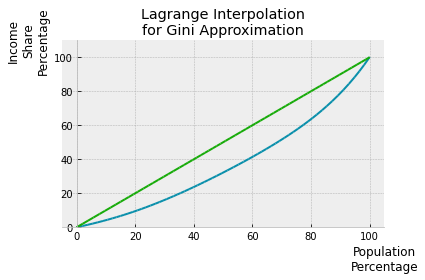



	NEWTON'S DIVIDED DIFFERENCE INTERPOLATION
----------------------------------------------------------------------------------------------------
Newton Polynomial:
 x*(1.71875e-8*x**4 - 2.86458333333333e-6*x**3 + 0.000146875*x**2 + 0.00302083333333334*x + 0.376)

Enclosed Area:  1305.76388888889

Equality Area:  5000

Gini Coefficient:  0.261152777777777

Accuracy: 97.45% 


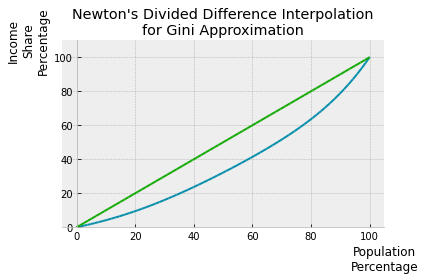



	LINEAR SPLINE INTERPOLATION
----------------------------------------------------------------------------------------------------
Linear Spline Polynomials:
0.475*x
0.71*x - 4.7
0.885*x - 11.7
1.11*x - 25.2
1.825*x - 82.4

Enclosed Area:  1235.00000000000

Equality Area:  5000

Gini Coefficient:  0.247000000000000

Accuracy: 92.16% 


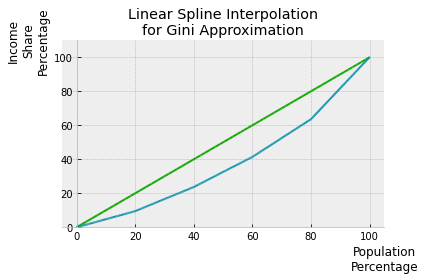



	CUBIC SPLINE INTERPOLATION
----------------------------------------------------------------------------------------------------
Cubic Spline Polynomials:
x*(0.00012822966507177*x**2 + 0.423708133971292)
-5.36483253588517e-5*x**3 + 0.0109126794258373*x**2 + 0.205454545454545*x + 1.45502392344498
-6.36363636363634e-5*x**3 + 0.0121112440191387*x**2 + 0.157511961722489*x + 2.09425837320573
0.000433193779904306*x**3 - 0.0773181818181817*x**2 + 5.52327751196172*x - 105.221052631579
-0.000444138755980861*x**3 + 0.133241626794258*x**2 - 11.3215071770335*x + 343.973205741626

Enclosed Area:  1287.63157894736

Equality Area:  5000

Gini Coefficient:  0.257526315789473

Accuracy: 96.09% 


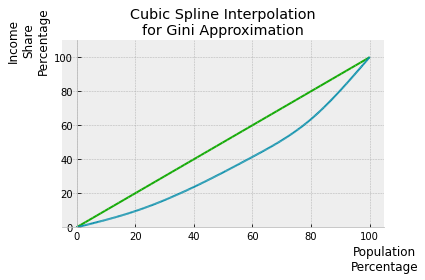

In [20]:
# ICELAND
known_gini = 0.2680  # Iceland's known Gini (2015)

calculateGiniForCountry('Iceland', known_gini)

In [ ]:
# INDIA
known_gini = 0.3570  # India's known Gini (2011)

calculateGiniForCountry('India', known_gini)

In [ ]:
# USA
known_gini = 0.4110  # USA's known gini (2016)

calculateGiniForCountry('USA', known_gini)

In [ ]:
# AFRICA
known_gini = 0.6300  # Africa's known gini (2014)

calculateGiniForCountry('Africa', known_gini)

In [ ]:
# Data source: https://databank.worldbank.org/reports.aspx?source=world-development-indicators